<h1 id="tocheading">1. CAPÍTULO II. LA GEODATABASE. Data Preparation</h1>
<div id="toc"></div>

In [1]:
'''
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')
'''

"\n%%javascript\n$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')\n"

En el presente notebook, se describen los procedimientos necesarios para  extraer la información de los ficheros descargados de la **Sede Electrónica de Catastro (SEC)**, preparando la base de datos para el trabajo de consultas.

Todo ello con el objetivo de aportar nuevas tablas con información derivada al analista o científico de datos, de forma que se pueda tener un conocimiento más preciso del territorio urbano y sus dinámicas edificatorias.

---
Como trabajo preliminar se deben haber realizado las siguientes tareas:

<div class="alert alert-info">

+ Descarga de **ficheros CAT (.gz)** desde la SEC.<br>
El fichero con el municipio escogido, al que se le asignará la variable **`archivo_gz`**, se debe haber ubicado en una carpeta a la que designaremos con la variable **`ruta`**

+ Descarga de **ficheros de geometría**> desde la SEC.<br>
A este fichero se le asignara la variable **`archivo_geom`**, y a su ruta: **`ruta_geom`**

+ Haber generado en POSTGRESQL> una database, a la que en el presente notebook asignaremos la variable **`database`**<br>

+ Ubicar los ficheros con las tablas de traducción de códigos:
 - **`T14_71.csv`**
 - **`T14_105_jc.csv`**
 - **`T15_428.csv`**<br>

 en la misma carpeta que el fichero **`.gz`**<br>

Para todas estas operaciones se recomienda que las **rutas no sean muy largas**. En este notebook, las rutas utilizadas son:
+ **`C:\Temp`**
+ **`C:\Temp\geom`** para ficheros de geometría.
</div>
---




# 2. Instalación e importación de paquetes.

 Comando específico de IPython y Jupyter Notebook que se utiliza para mostrar los gráficos dentro de la misma celda del Jupyter Notebook en lugar de abrir una ventana emergente.

In [2]:
# Declare inline graphics
# para que los gráficos se representen en el notebook por defecto
%matplotlib inline

Se actualizan los paquetes de `Python` a la última versión disponible.<br>
No obstante, en caso de problemas, las versiones con las que se ha realizado el presente notebook son:

---
+ Python: 3.10.10
+ Anaconda: conda 23.3.1
+ Jupyter Notebooks: 6.5.3
+ PostgreSQL: postgres (PostgreSQL) 14.2
---
+ numpy: 1.24.2
+ pandas: 1.5.3
+ matplotlib: 3.7.1
+ geopandas: 0.13.2
+ psycopg2: 2.9.7
+ sqlalchemy: 2.0.20
---

In [ ]:
# Instalación de los paquetes necesarios

'''
!pip install --upgrade setuptools
!pip install --upgrade psycopg2
!pip install --upgrade pygresql
!pip install --upgrade sqlalchemy
!pip install --upgrade chk
!pip install --upgrade geopandas
!pip install --upgrade geoalchemy2
'''

Importamos las librerías:

In [3]:
import sys
import random
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import warnings
import psycopg2
from sqlalchemy import create_engine

import gzip
import io
from io import StringIO
import pkg_resources
import subprocess
import datetime

Comprobamos las **versiones de los paquetes** especificados, así como la versión de `Python` y la versión de `PostgreSQL` en el sistema.<br>
Es útil para verificar la configuración y las dependencias de un entorno de desarrollo.

In [4]:
# Lista de paquetes a verificar
paquetes = ['sys','random', 'numpy', 'pandas', 'geopandas', 'matplotlib',
            'warnings', 'psycopg2', 'sqlalchemy', 'gzip', 'io']


# Obtener y mostrar las versiones de los paquetes
for paquete in paquetes:
    try:
        version = pkg_resources.get_distribution(paquete).version
        print(f'{paquete}: {version}')
    except pkg_resources.DistributionNotFound:
        print(f'{paquete}: No se encontró el paquete')

# Consultar la versión de Python
python_version = sys.version.split()[0]
print(f'Python: {python_version}')

# Consultar la versión de PostgreSQL
try:
    postgres_version = subprocess.check_output(['postgres', '--version'], universal_newlines=True)
    print(f'PostgreSQL: {postgres_version.strip()}')
except subprocess.CalledProcessError:
    print('PostgreSQL: No se encontró PostgreSQL')

sys: No se encontró el paquete
random: No se encontró el paquete
numpy: 1.24.2
pandas: 1.5.3
geopandas: 0.13.2
matplotlib: 3.7.1
warnings: No se encontró el paquete
psycopg2: 2.9.7
sqlalchemy: 2.0.20
gzip: No se encontró el paquete
io: No se encontró el paquete
Python: 3.10.10
PostgreSQL: postgres (PostgreSQL) 14.2


**Personalizamos la apariencia y el estilo de las gráficas** generadas con la biblioteca Matplotlib.<br> 
Cambiamos el tamaño predeterminado de las figuras y establecer el fondo en blanco.<br> 
Estas personalizaciones afectarán a todas las gráficas que se generen.

In [5]:
# Initialize the plotting space
# Carga de un estilo
plt.style.use('bmh')

# Modificamos parámetros del estilo
plt.rcParams['figure.figsize'] = 16, 6;
plt.rcParams['figure.facecolor'] = 'white';

Se desactivan las advertencias sólo a efecto de limpieza del notebook.<br>
Son ***útiles al proporcionar información sobre el comportamiento del código y prácticas que podrían estar obsoletas***.

In [6]:
# Evitar la aparición de warnings
# Ignorar una advertencia específica por su categoría
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 3. Conexión a la Base de Datos.

 Establecemos una conexión a una base de datos `PostgreSQL` utilizando los parámetros de conexión proporcionados.<br>

---
Parámetros de Conexión:

<div class="alert alert-info">
    
En su caso, deben declararse las siguientes variables en la siguiente celda:

+ **`host`** :
Dirección o nombre del servidor de la base de datos PostgreSQL.
+ **`pgport`** :
Número de puerto en el que PostgreSQL está escuchando. Por lo general, es **5432**.
+ **`database`** :
Nombre de la base de datos a la que se desea conectar.
+ **`user`** :
Nombre de usuario para la autenticación.
+ **`password`** :
Contraseña para la autenticación.
+ **`pg_bin_path`** :
Ruta al directorio binario de PostgreSQL en el sistema.
</div>
---

In [7]:
# Parámetros de conexión
host = "localhost"
pgport = 5432
database = "cat" # database a la que conectarse
user = "postgres" #owner
password = "postgres"
pg_bin_path = r'c:\\PostgreSQL\\14\\bin'

try:
    # Conexión a la base de datos PostgreSQL
    conexion = psycopg2.connect(
        host=host,
        database=database,
        user=user,
        password=password
    )

    # Crear un cursor
    cursor = conexion.cursor()

    print(f"La base de datos {database}' se ha conectado con éxito.")

except (Exception, psycopg2.Error) as error:
    print(f"Error al conectar a la base de datos: '{database}'", error)

La base de datos cat' se ha conectado con éxito.


# 4. Creación de los esquemas y extensiones.

## 4.1. Declaración de las variables a usar en el procesado.

---
Se declaran las ubicaciones y nombres de archivos que se utilizarán en el procesado de los datos:

<div class="alert alert-info"> 
    
+ **`ruta`** : Ruta donde se va a ubicar el fichero CAT seleccionado de extensión `.gz`
    
+ **`ruta_geom`** : Ruta donde se va a ubicar el fichero de geometría. El tipo de fichero es `.shp`, aunque en futuras propuestas del script del TFM se pretende operar también con ficheros de tipo `.json`.

+ **`archivo_gz`**  :Nombre del Fichero CAT `.gz` descargado de la SEC.

+ **`archivo_geom`** : Nombre del fichero de  geometría `.shp`.
    
+ **`municipio`** : Nombre que se asigna al esquema donde se alojarán las tablas a generar. Se recomienda el nombre del municipio donde se va a realizar la investigación.

+ **`tabla_geom`** : Nombre que se asigna a la tabla donde se cargan las geometrías de parcela.
    
+ **`t15_428_csv`** : **No cambiar**. Nombre asignado al fichero de codificación de los ***Usos de los bienes inmuebles***.
    
+ **`t14_71_csv`** : **No cambiar**. Nombre asignado al fichero de codificación de las ***Tipologías y Categorías de las construcciones***, según la Norma 20 del Real Decreto 1020/1993 de 25 de junio.
    
+ **`t14_105_csv`** : **No cambiar**. Nombre asignado al fichero de codificación de lass ***Subcategorías de los Usos para los distintas recintos de los bienes inmuebles***.

+ **`current_year`** : Año actual.
</div>
---

In [8]:
# Definición de las rutas y nombres de archivos
ruta = 'c:\\Temp\\'
ruta_geom = 'c:\\Temp\\geom\\'

archivo_gz = '14900U_23062023.CAT.gz'
archivo_geom = 'PARCELA.SHP'
municipio = 'cordoba'
tabla_geom = 'parcel' # Nombre que queremos dar a la tabla

t15_428_csv = 'T15_428.csv'
t14_71_csv = 'T14_71.csv'
t14_105_csv = 'T14_105_jc.csv'

# Automática
current_year=datetime.datetime.now().year

## 4.2. Limpieza de la Base de Datos.

Se limpian y eliminan las tablas y esquemas prexistentes de la base de datos PostgreSQL, para facilitar el trabajo de procesado.

In [9]:
# ELIMINACIÓN DE TABLAS
# Lista de nombres de las tablas a eliminar
tablas_a_eliminar = ["t15", "t14", "t13", "t11", tabla_geom]
tablas_a_eliminar_2 =["t15_428", "t14_71", "t14_105"]

try:
    # Itera sobre la lista de tablas y ejecuta DROP TABLE para cada una
    for tabla in tablas_a_eliminar:
        sql = f"DROP TABLE IF EXISTS {municipio}.{tabla};"
        cursor.execute(sql)

    for tabla in tablas_a_eliminar_2:
        sql = f"DROP TABLE IF EXISTS cod.{tabla};"
        cursor.execute(sql)

    # Confirma los cambios
    conexion.commit()

    print("Tablas eliminadas con éxito.")

except (Exception, psycopg2.Error) as error:
    print("Error al eliminar las tablas:", error)


# ELIMINACIÓN DE ESQUEMAS
# Lista de nombres de los esquemas a eliminar
esquemas_a_eliminar = [municipio, "cod"]

try:
    # Itera sobre la lista de esquemas y ejecuta DROP SCHEMA para cada uno
    for esquema in esquemas_a_eliminar:
        sql = f"DROP SCHEMA IF EXISTS {esquema} CASCADE;"
        cursor.execute(sql)

    # Confirma los cambios
    conexion.commit()

    print("Esquemas eliminados con éxito.")

except (Exception, psycopg2.Error) as error:
    print("Error al eliminar los esquemas:", error)

Tablas eliminadas con éxito.
Esquemas eliminados con éxito.


## 4.3. Creación de los Esquemas(shchemas) de la Base de Datos.
Creamos los esquemas de la base de datos PostgreSQL, utilizando la biblioteca `psycopg2`. Esto permitirá organizar y separar objetos de la BBDD en grupos distintos, para gestionar los datos de manera más eficiente y estructurada.

In [10]:
# CREACIÓN DE LOS ESQUEMAS
try:
    # Consulta SQL para crear el esquema "cod" si no existe
    sql_cod = "CREATE SCHEMA IF NOT EXISTS cod;"

    # Consulta SQL para crear el esquema personalizado si no existe
    sql_municipio = f"CREATE SCHEMA IF NOT EXISTS {municipio};"

    # Ejecutar las consultas
    cursor.execute(sql_cod)
    cursor.execute(sql_municipio)

    # Confirmar los cambios
    conexion.commit()

    print(f"Los esquemas 'cod' y '{municipio}' han sido creados con éxito en la base de datos '{database}'")

except (Exception, psycopg2.Error) as error:
    print("Error al crear los esquemas:", error)

Los esquemas 'cod' y 'cordoba' han sido creados con éxito en la base de datos 'cat'


Mostramos los nombres de los esquemas existentes en la base de datos PostgreSQL para confirmar que han sido creados.

In [11]:
# Listado de los esquemas en la base de datos actualmente conectada
try:
    # Consulta SQL para listar los esquemas
    cursor.execute("SELECT schema_name FROM information_schema.schemata;")

    # Obtener los resultados
    esquemas = cursor.fetchall()

    # Imprimir los nombres de los esquemas
    print(f'Los esquemas disponibles en la base de datos {municipio} son los siguientes:')
    for esquema in esquemas:
        print(esquema[0])

except (Exception, psycopg2.Error) as error:
    print(f"Error al listar los esquemas:", error)

Los esquemas disponibles en la base de datos cordoba son los siguientes:
pg_toast
pg_catalog
public
information_schema
cod
cordoba


## 4.4. Carga de las extensiones necesarias de la Base de Datos.

Agregamos funcionalidades adicionales a la base de datos PostgreSQL instalando las extensiones:
- **`POSTGIS`**
- **`TABLEFUNC`**

Estas extensiones son comunes en aplicaciones que requieren **capacidades geoespaciales** o **funcionalidades SQL avanzadas**, tal y como es nuestro caso.

In [12]:
# EXTENSIONES
try:
    # Crear extensión POSTGIS
    cursor.execute("CREATE EXTENSION IF NOT EXISTS postgis;")

    # Crear extensión tablefunc
    cursor.execute("CREATE EXTENSION IF NOT EXISTS tablefunc;")

    # Confirmar los cambios
    conexion.commit()

    print("Extensiones POSTGIS y TABLEFUNC instaladas correctamente")

except (Exception, psycopg2.Error) as error:
    print("Error al instalar las extensiones POSTGIS y tablefunc:", error)

Extensiones POSTGIS y TABLEFUNC instaladas correctamente


# 5.Tablas de traducción de códigos de Catastro.

En la siguientes celdas de produce la carga en la base de datos de unas***generadas para el TFM***, con el propósito de traducir los códigos empleados por Catastro en varios de los campos pertenecientes a los rgistros `t15` y `t14`. Por ejemplo:<br>
<br>
+ ***`CCL`***</font> es un uso **`COMERCIAL`** destinado a **`Calzado`**.
+ ***`01123`***</font> es una tipología **`RESIDENCIAL`** de tipo **`VIV COLECTIVA CARACTER URBANO`**, en **`MANZANA CERRADA (VIV PLURIF)`**, de categoría **`3`**.

**Descripción de las tablas**

|Tabla|descripción
| :- | :------------- |
|**`t15_428`**|Codificación de los Usos de los bienes inmuebles.
|**`t14_105`**|Codificación de las Subcategorías de los Usos para los distintas recintos de los bienes inmuebles.
|**`t14_71`**|Codificación de las Tipologías y Categorías de las construcciones, según la Norma 20 del Real Decreto 1020/1993 de 25 de junio.

## 5.1. Tabla `t15_428`. Usos de los BI.
Se crea la tabla en la bbdd de PostgreSQL, verificando que se haya creado correctamente y comunicando  si ocurren errores durante el proceso de creación.

In [13]:
# Tabla T15_428
sql = '''CREATE TABLE IF NOT EXISTS cod.t15_428 (
    id15428 serial NOT NULL,
    coduso_428 character varying(1),
    uso15428 character varying(100),
    PRIMARY KEY (id15428)
)'''

try:
    # Ejecutar la consulta SQL para crear la tabla
    cursor.execute(sql)

    # Confirmar los cambios en la conexión
    conexion.commit()

    # Verificar que la tabla se haya creado correctamente
    cursor.execute("SELECT EXISTS (SELECT 1 FROM information_schema.tables WHERE table_schema = 'cod' AND table_name = 't15_428');")
    table_exists = cursor.fetchone()[0]

    if table_exists:
        print("La tabla 't15_428' se creó con éxito en el esquema 'cod'.")
    else:
        print("La tabla 't15_428' no se creó en el esquema 'cod'.")

except (Exception, psycopg2.Error) as error:
    # En caso de error, imprimir el mensaje de error y realizar un rollback para deshacer los cambios
    print("Error al crear la tabla:", error)
    conexion.rollback()

La tabla 't15_428' se creó con éxito en el esquema 'cod'.


Se cargan los datos desde el archivo `t15_428.csv` en la tabla de la bbdd (creada en la celda anterior), utilizando la operación `COPY`.

In [14]:
try:
    # Consulta SQL para realizar la operación COPY en la tabla T15_428
    sql = f'''COPY cod.t15_428 (coduso_428, uso15428)
    FROM '{ruta}{t15_428_csv}'
    DELIMITER ';'
    CSV HEADER;
    '''

    # Ejecutar la consulta para cargar los datos
    cursor.execute(sql)

    # Confirmar los cambios
    conexion.commit()

    print("Datos copiados a la tabla 't15_428'")

except (Exception, psycopg2.Error) as error:
    print("Error al cargar los datos:", error)

Datos copiados a la tabla 't15_428'


## 5.2. Tabla `t14_105`.	Subcategorías de los Usos para los distintos recintos de los B.I.
Se crea la tabla en la bbdd de PostgreSQL, verificando que se haya creado correctamente y comunicando  si ocurren errores durante el proceso de creación.

In [15]:
try:
    # Consulta SQL para crear la tabla T14_105
    sql = '''CREATE TABLE IF NOT EXISTS cod.t14_105 (
        id14105 serial NOT NULL,
        tip_105 character varying(5),
        uso1 character varying(25),
        tipolog1 character varying(50),
        tipolog2 character varying(50),
        categ smallint,
        categ2 smallint,
        coef real,
        PRIMARY KEY (id14105)
    );'''

    # Ejecutar la consulta para crear la tabla
    cursor.execute(sql)

    # Confirmar los cambios
    conexion.commit()

    print("La tabla 't14_105' se creó con éxito en el esquema 'cod'.")

except (Exception, psycopg2.Error) as error:
    print("Error al crear la tabla 't14_105':", error)

La tabla 't14_105' se creó con éxito en el esquema 'cod'.


Se cargan los datos desde el archivo `t14_105.csv` en la tabla de la bbdd (creada en la celda anterior), utilizando la operación `COPY`.

In [16]:
try:
    # Consulta SQL para realizar la operación COPY en la tabla T14_105
    sql = f'''COPY cod.t14_105 (tip_105, uso1, tipolog1, tipolog2, categ, categ2, coef)
    FROM '{ruta}{t14_105_csv}'
    DELIMITER ';'
    CSV HEADER;
    '''

    # Ejecutar la consulta para realizar la operación COPY
    cursor.execute(sql)

    # Confirmar los cambios
    conexion.commit()

    print("Datos copiados a la tabla 't14_105'")

except (Exception, psycopg2.Error) as error:
    print("Error en la operación COPY a 't14_105':", error)

Datos copiados a la tabla 't14_105'


## 5.3. Tabla `t14_71`. Tipologías y Categorías de las construcciones (Recintos de Uso).
Se crea la tabla en la bbdd de PostgreSQL, verificando que se haya creado correctamente y comunicando  si ocurren errores durante el proceso de creación.

In [17]:
try:
    # Consulta SQL para crear la tabla T14_71
    sql_create_table = '''CREATE TABLE IF NOT EXISTS cod.t14_71 (
        id1471 serial NOT NULL,
        cd_71 character varying(3),
        uso_bi character varying(25),
        act_71_14 character varying(100),
        coduso_bi character varying(1),
        PRIMARY KEY (id1471)
    );'''

    # Ejecutar la consulta para crear la tabla
    cursor.execute(sql_create_table)

    # Confirmar los cambios
    conexion.commit()

    print("La tabla 't14_71' se creó con éxito en el esquema 'cod'.")

except (Exception, psycopg2.Error) as error:
    print("Error en la creación de la tabla 't14_71':", error)

La tabla 't14_71' se creó con éxito en el esquema 'cod'.


Se cargan los datos desde el archivo `t14_71.csv` en la tabla de la bbdd (creada en la celda anterior), utilizando la operación `COPY`.

In [18]:
try:
    # Consulta SQL para realizar la operación COPY en la tabla T14_71
    sql = f'''COPY cod.t14_71 (cd_71, uso_bi, act_71_14, coduso_bi)
        FROM '{ruta}{t14_71_csv}'
        DELIMITER ','
        CSV HEADER;
    '''

    # Ejecutar la consulta para copiar los datos
    cursor.execute(sql)

    # Confirmar los cambios
    conexion.commit()

    print("La tabla 't14_71' se creó con éxito en el esquema 'cod'.")

except (Exception, psycopg2.Error) as error:
    print("Error al copiar los datos a la tabla 't14_71':", error)

La tabla 't14_71' se creó con éxito en el esquema 'cod'.


Realizar una consulta SQL en la base de datos PostgreSQL para cargar los resultados a un `DataFrame` de `Pandas`, al objeto de condirmar nuevamente que los precesos se han efectuado correctamente.

In [19]:
sql = 'select * from cod.t14_105'

# cursor.execute(sql)
# print(cursor.fetchmany(size=3))

# en Pandas
df = pd.read_sql_query(sql, conexion)
df

C:\Users\jcric\AppData\Local\Temp\ipykernel_2952\3564705939.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conexion)


,id14105,tip_105,uso1,tipolog1,tipolog2,categ,categ2,coef
0,1,0111,RESIDENCIAL,PLURIFAMILIAR,EDIFICACIÓN ABIERTA,4,7,1.0500
1,2,0111A,RESIDENCIAL,PLURIFAMILIAR,EDIFICACIÓN ABIERTA,1,1,2.4750
2,3,0111B,RESIDENCIAL,PLURIFAMILIAR,EDIFICACIÓN ABIERTA,1,2,2.1450
3,4,0111C,RESIDENCIAL,PLURIFAMILIAR,EDIFICACIÓN ABIERTA,1,3,1.8975
4,5,01111,RESIDENCIAL,PLURIFAMILIAR,EDIFICACIÓN ABIERTA,1,4,1.6500
...,...,...,...,...,...,...,...,...
954,955,HANG,SINGULAR,SINGULAR,AERÓDROMO,1,4,2.2000
955,956,SINGU,SINGULAR,SINGULAR,SINGULAR,0,0,0.0000
956,957,ANTEN,INSTALACION,INSTALACION,ANTENA,0,0,0.0000
957,958,5623,ESPECTÁCULOS,CINES Y TEATROS,TEATROS,3,6,2.1500


# 6. Importación a Base de Datos de la estructura CAT.

Comenzamos a procesar el fichero CAT<br>
Se trata de un fichero comprimido en formato  `.gz`, codificado en `latin1`.<br>

+ Se define la ruta completa del archivo comprimido `.gz`.

+ Utilizamos la función `gzip.open()` para abrir el archivo comprimido en modo de lectura de texto `rt`con codificación `latin1`.

+ Lee el contenido del archivo línea por línea y se almacena en la variable `lineas`. Cada línea del archivo `.gz` se convierte en un elemento de la lista `lineas`.<br>


+ **LA "LAVADORA".**

  - Se define una lista llamada `caracteres` que contiene aquellos que debemos reemplazar del archivo. Son debidos a ***errores humanos*** en la transcripción a formulario de los datos catastrales.

  - Con un bucle anidado recorremos todas las líneas en la lista y reemplazamos los caracteres anteriores.

+ Por último generamos un DataFrame llamado `data_cat` utilizando las líneas procesadas, y creando una única columna llamada '`id`' que contiene el contenido de cada línea. (1.000 caracteres)

In [20]:
# tiempo en ejecutar la celda en tiempo transcurrido y tiempo de CPU.
# %%time

# Tratamiento del archivo .gz

# Ruta del archivo comprimido utilizando las variables definidas
cat_gz = ruta + archivo_gz

# lee el archivo gz
with gzip.open(cat_gz, 'rt', encoding='latin1') as fichero_in:
    # Leer todas las líneas del archivo gz en una lista
    lineas = fichero_in.readlines()

# La Lavadora
caracteres = ["'", '"', '\\', '/', ',', '!', '?' , '#', '$', '%', '&', '*', ':',
       ';', '=', '@', '[', ']', '^', '_', '`', '{', '|', '}', '~', '>', '<','\t']

# Reemplazar caracteres en cada línea individualmente
for i in range(len(lineas)):
    for char in caracteres:
        if char == ',':
            lineas[i] = lineas[i].replace(char, '.')
        else:
            lineas[i] = lineas[i].replace(char, ' ')

# generamos el dataframe a partir de la lista
data_cat = pd.DataFrame({'id': lineas})

Definimos la función `try_convert_to_int`.<br>
La función tiene como objetivo **convertir una cadena que representa un número entero en un entero**.<br>
Si la conversión falla, debido a una cadena vacía u otro valor no válido, devolverá `None`.<br>
Aplicaremos esta función a las columnas que podrían contener cadenas vacías antes de la conversión, evitando errores y manejando de manera adecuada los casos en los que los datos no son válidos.

In [21]:
# Convertir columnas con manejo de cadenas vacías
def try_convert_to_int(value):
    try:
        return int(value)
    except ValueError:
        return None

 A partir del DataFrame `data_cat`:<br>
 Generamos mediante extracción de subcadenas y conversiones de la cadena alfanumérica `id`  (aplicación de la función `try_convert_to_int`, y el borrado de caracteres con `.strip()` ), los nuevos DataFrames `df_t15`, `df_t14`, `df_t13`, `df_t11`.

## 6.1. Creación del DataFrame `df_t15`. Bienes Inmuebles.

Se muestra en la tabla los fragmentos a extraer y su significado:

|codigo|tipo|inicio|final|descripción
| :- | :------------- | :------------- | :------------- | :------------- |
|**`tipo_29`**|character|28|30|Clase del Bien inmueble (UR, RU, BI) 
|**`pc_31`**|character|30|44|Parcela catastral. 
|**`car_45`**|character|44|48|Número secuencial del bien inmueble 
|**`cc1_49`**|character|48|49|Primer carácter de control 
|**`cc2_50`**|character|49|50|Segundo carácter de control 
|**`nfbi_51`**|integer|50|58|Número fijo del Bien Inmueble 
|**`nfv_74`**|varchar|73|92|Número de finca registral, incluyendo registro de la propiedad 
|**`es_250`**|varchar|249|251|Escalera 
|**`pt_252`**|varchar|251|254|Planta 
|**`pu_255`**|varchar|254|257|Puerta 
|**`noe_368`**|varchar|367|371|Número de orden del inmueble en la escritura de división horizontal 
|**`ant_372`**|smallint|371|375|Año de antigüedad del bien inmueble 
|**`coduso_428`**|character|427|428|Usos 
|**`sfc_442`**|integer|441|451|Superficie oficial del bien inmueble 
|**`sfs_452`**|integer|451|461|Superficie asociada al inmueble 
|**`cpt_462`**|integer|461|470|Coeficiente de propiedad respecto a la finca 

In [22]:
# Dataframe t15 de Bienes Inmuebles
#  independiente de cat y no como una vista

# Filtrar las filas de 'cat' que comienza con '15'
df_t15 = data_cat [data_cat['id'].str.startswith('15')].copy()

# Aplicar las extracciones y conversiones
df_t15.loc[:, 'tipo_29'] = df_t15['id'].str[28:30]
df_t15.loc[:, 'pc_31'] = df_t15['id'].str[30:44]
df_t15.loc[:, 'car_45'] = df_t15['id'].str[44:48]
df_t15.loc[:, 'cc1_49'] = df_t15['id'].str[48:49]
df_t15.loc[:, 'cc2_50'] = df_t15['id'].str[49:50]
df_t15.loc[:, 'nfbi_51'] = df_t15['id'].str[50:58].apply(try_convert_to_int)
df_t15.loc[:, 'nfv_74'] = df_t15['id'].str[73:92].str.strip()
df_t15.loc[:, 'es_250'] = df_t15['id'].str[249:251].str.strip()
df_t15.loc[:, 'pt_252'] = df_t15['id'].str[251:254].str.strip()
df_t15.loc[:, 'pu_255'] = df_t15['id'].str[254:257].str.strip()
df_t15.loc[:, 'noe_368'] = df_t15['id'].str[367:371].str.strip()
df_t15.loc[:, 'ant_372'] = df_t15['id'].str[371:375].apply(try_convert_to_int)
df_t15.loc[:, 'coduso_428'] = df_t15['id'].str[427:428].str.strip()
df_t15.loc[:, 'sfc_442'] = df_t15['id'].str[441:451].apply(try_convert_to_int)
df_t15.loc[:, 'sfs_452'] = df_t15['id'].str[451:461].apply(try_convert_to_int)
df_t15.loc[:, 'cpt_462'] = df_t15['id'].str[461:470].apply(try_convert_to_int)

# Filtrar y actualizar los valores
df_t15.loc[df_t15['ant_372'] <= 0, 'ant_372'] = None
df_t15.loc[df_t15['ant_372'] > current_year, 'ant_372'] = None

# Eliminar el campo 'id'
df_t15 = df_t15.drop(columns=['id'])

## 6.2. Creación del DataFrame `df_t14`. Construcciones (Recintos de uso) de los B.I.

Se muestra en la tabla los fragmentos a extraer y su significado:

|codigo|tipo|inicio|final|descripción
| :- | :------------- | :------------- | :------------- | :------------- |
|**`pc_31`**|character|30|44|Parcela catastral
|**`noec_45`**|character|44|48|Número de orden del elemento de construcción
|**`nobf_51`**|character|50|54|Número de orden del bien inmueble fiscal
|**`cuc_55`**|character|54|58|Código de la Unidad Constructiva a la que está asociado el local.
|**`es_63`**|varchar|62|64|Escalera
|**`pt_65`**|varchar|64|67|Planta
|**`pu_68`**|varchar|67|70|Puerta
|**`cd_71`**|varchar|70|73|Código de Destino. Descripción de la Actividad
|**`tr_74`**|character|73|74|Indicador del tipo de reforma o rehabilitación,
|**`ar_75`**|smallint|74|78|Año de reforma
|**`aec_79`**|smallint|78|82|Año de antigüedad efectiva en Catastro
|**`ili_83`**|character|82|83|Indicador de local interior
|**`stl_84`**|integer|83|90|Superficie total del local a efectos de catastro
|**`spt_91`**|integer|90|97|Superficie de porches y terrazas del local
|**`sil_98`**|integer|97|104|Superficie imputable al local situada en otras plantas
|**`tip_105`**|character|104|109|Tipología constructiva
|**`modl_112`**|character|111|114|Código de Modalidad de Reparto

In [23]:
# Dataframe t14 de Construcciones (locales)
# lo genero como un dataframe independiente de cat

# Filtrar las filas de 'cat' que comienzan con '14'
df_t14 = data_cat[data_cat['id'].str.startswith('14')].copy()

# Aplicar las extracciones y conversiones
df_t14.loc[:, 'pc_31'] = df_t14['id'].str[30:44]
df_t14.loc[:, 'noec_45'] = df_t14['id'].str[44:48]
df_t14.loc[:, 'nobf_51'] = df_t14['id'].str[50:54]
df_t14.loc[:, 'cuc_55'] = df_t14['id'].str[54:58].str.strip()
df_t14.loc[:, 'es_63'] = df_t14['id'].str[62:64].str.strip()
df_t14.loc[:, 'pt_65'] = df_t14['id'].str[64:67].str.strip()
df_t14.loc[:, 'pu_68'] = df_t14['id'].str[67:70].str.strip()
df_t14.loc[:, 'cd_71'] = df_t14['id'].str[70:73].str.strip()
df_t14.loc[:, 'tr_74'] = df_t14['id'].str[73:74].str.strip()
df_t14.loc[:, 'ar_75'] = df_t14['id'].str[74:78].apply(try_convert_to_int)
df_t14.loc[:, 'aec_79'] = df_t14['id'].str[78:82].apply(try_convert_to_int)
df_t14.loc[:, 'ili_83'] = df_t14['id'].str[82:83].str.strip()
df_t14.loc[:, 'stl_84'] = df_t14['id'].str[83:90].apply(try_convert_to_int)
df_t14.loc[:, 'spt_91'] = df_t14['id'].str[90:97].apply(try_convert_to_int)
df_t14.loc[:, 'sil_98'] = df_t14['id'].str[97:104].apply(try_convert_to_int)
df_t14.loc[:, 'tip_105'] = df_t14['id'].str[104:109].str.strip()
df_t14.loc[:, 'modl_112'] = df_t14['id'].str[111:114].str.strip()


# Filtrar y actualizar los valores
df_t14.loc[df_t14['aec_79'] <= 0, 'aec_79'] = None
df_t14.loc[df_t14['aec_79'] > current_year, 'aec_79'] = None

# Eliminar la columna 'id'
df_t14 = df_t14.drop(columns=['id'])

## 6.3. Creación del DataFrame `df_t13`. Unidades Constructivas de los B.I.

Se muestra en la tabla los fragmentos a extraer y su significado:

|codigo|tipo|inicio|final|descripción
| :- | :------------- | :------------- | :------------- | :------------- |
|**`pc_31`**|character|30|44|Parcela catastral.
|**`cn_29`**|character|28|30|Clase de la Unidad Constructiva (UR, RU, BI)
|**`cuc_45`**|character|44|48|Código de la unidad Constructiva.
|**`ac_296`**|smallint|295|299|Año de la construcción (formato (AAAA))
|**`iacons_300`**|character|299|309|Indicador de exactitud del año de construcción
|**`so_301`**|integer|308|315|Superficie de suelo ocupada por la Unidad Constructiva en m2
|**`lf_308`**|integer|409|413|Longitud de fachada (en cm)
|**`cucm_410`**|varchar|409|413|Código de la Unidad Constructiva Matriz

In [24]:
# Dataframe t13 de Unidades Constructivas
# lo genero como un dataframe independiente de cat

# Filtrar las filas de 'cat' que comienzan con '13'
df_t13 = data_cat[data_cat['id'].str.startswith('13')].copy()

# Aplicar las extracciones y conversiones
df_t13.loc[:, 'pc_31'] = df_t13['id'].str[30:44]
df_t13.loc[:, 'cn_29'] = df_t13['id'].str[28:30]
df_t13.loc[:, 'cuc_45'] = df_t13['id'].str[44:48].str.strip()
df_t13.loc[:, 'ac_296'] = df_t13['id'].str[295:299].apply(try_convert_to_int)
df_t13.loc[:, 'iacons_300'] = df_t13['id'].str[299:309].str.strip()
df_t13.loc[:, 'so_301'] = df_t13['id'].str[308:315].apply(try_convert_to_int)
df_t13.loc[:, 'lf_308'] = df_t13['id'].str[409:413].apply(try_convert_to_int)
df_t13.loc[:, 'cucm_410'] = df_t13['id'].str[409:413].str.strip()

# Eliminar la columna 'id'
df_t13 = df_t13.drop(columns=['id'])

## 6.4. Creación del DataFrame `df_t11`. Fincas / Parcelas.

Se muestra en la tabla los fragmentos a extraer y su significado:

|codigo|tipo|inicio|final|descripción
| :- | :------------- | :------------- | :------------- | :------------- |
|**`pc_31`**|character|30|44|Parcela catastral
|**`cp_51`**|character|50|52|Código de Provincia (INE)
|**`np_53`**|varchar|52|77|Nombre Provincia
|**`mc_81`**|character|80|83|Código de Municipio (INE)
|**`nm_84`**|varchar|83|123|Nombre del Municipio
|**`nem_124`**|varchar|123|153|Nombre de la entidad menor, en caso de existir
|**`cv_154`**|integer|153|158|Código de vía pública
|**`tv_159`**|varchar|158|163|Tipo de vía o sigla pública
|**`nv_164`**|varchar|163|188|Nombre de la vía pública
|**`pnp_189`**|smallint|188|192|Primer número de policía
|**`plp_193`**|character|192|193|Primera letra
|**`snp_194`**|smallint|193|197|Segundo número de policía
|**`slp_198`**|character|197|198|Segunda letra
|**`km_199`**|integer|198|203|Kilómetro
|**`bl_204`**|varchar|203|207|Bloque
|**`p_241`**|integer|240|245|Código postal
|**`cpo_253`**|smallint|252|255|Código de polígono rústico
|**`cpa_256`**|smallint|255|260|Código de parcela
|**`cpaj_261`**|character|260|265|Código del paraje
|**`npa_266`**|varchar|265|295|Nombre del paraje
|**`sup_296`**|integer|295|305|Superficie de la finca o parcela catastral (en m2).
|**`sct_306`**|integer|305|312|Superficie construida total
|**`ssr_313`**|integer|312|319|Superficie construida sobre rasante
|**`sbr_320`**|integer|319|326|Superficie construida bajo rasante
|**`sc_327`**|integer|326|333|Superficie cubierta

In [25]:
# Dataframe t11 de Fincas / Parcelas
# lo genero como un dataframe independiente de cat

# Filtrar las filas de 'cat' que comienzan con '11'
df_t11 = data_cat[data_cat['id'].str.startswith('11')].copy()

# Aplicar las extracciones y conversiones con manejo de cadenas vacías
df_t11.loc[:, 'pc_31'] = df_t11['id'].str[30:44]
df_t11.loc[:, 'cp_51'] = df_t11['id'].str[50:52].apply(try_convert_to_int)
df_t11.loc[:, 'np_53'] = df_t11['id'].str[52:77].str.strip()
df_t11.loc[:, 'mc_81'] = df_t11['id'].str[80:83].str.strip()
df_t11.loc[:, 'nm_84'] = df_t11['id'].str[83:123].str.strip()
df_t11.loc[:, 'nem_124'] = df_t11['id'].str[123:153].str.strip()
df_t11.loc[:, 'cv_154'] = df_t11['id'].str[153:158].apply(try_convert_to_int)
df_t11.loc[:, 'tv_159'] = df_t11['id'].str[158:163].str.strip()
df_t11.loc[:, 'nv_164'] = df_t11['id'].str[163:188].str.strip()
df_t11.loc[:, 'pnp_189'] = df_t11['id'].str[188:192].apply(try_convert_to_int)
df_t11.loc[:, 'plp_193'] = df_t11['id'].str[192:193].str.strip()
df_t11.loc[:, 'snp_194'] = df_t11['id'].str[193:197].apply(try_convert_to_int)
df_t11.loc[:, 'slp_198'] = df_t11['id'].str[197:198].str.strip()
df_t11.loc[:, 'km_199'] = df_t11['id'].str[198:203].apply(try_convert_to_int)
df_t11.loc[:, 'bl_204'] = df_t11['id'].str[203:207].str.strip()
df_t11.loc[:, 'p_241'] = df_t11['id'].str[240:245]
df_t11.loc[:, 'cpo_253'] = df_t11['id'].str[252:255].apply(try_convert_to_int)
df_t11.loc[:, 'cpa_256'] = df_t11['id'].str[255:260].apply(try_convert_to_int)
df_t11.loc[:, 'cpaj_261'] = df_t11['id'].str[260:265].str.strip()
df_t11.loc[:, 'npa_266'] = df_t11['id'].str[265:295].str.strip()
df_t11.loc[:, 'sup_296'] = df_t11['id'].str[295:305].apply(try_convert_to_int)
df_t11.loc[:, 'sct_306'] = df_t11['id'].str[305:312].apply(try_convert_to_int)
df_t11.loc[:, 'ssr_313'] = df_t11['id'].str[312:319].apply(try_convert_to_int)
df_t11.loc[:, 'sbr_320'] = df_t11['id'].str[319:326].apply(try_convert_to_int)
df_t11.loc[:, 'sc_327'] = df_t11['id'].str[326:333].apply(try_convert_to_int)

# Eliminar la columna 'id' si es necesario
df_t11 = df_t11.drop(columns=['id'])

## 6.5. Carga de `df_t15`, `df_t14`, `df_t13` y `df_t11` a la Base de Datos.

Al trabajar con un solo municipio, borramos **campos redundantes** del DataFrame `df_t11`, los cuales se repiten en todas las filas, y consumen memoria.<br>

Así mismo, eliminamos el DataFrame `data_cat` que ya no emplearemos más.

In [26]:
# BORRAR CAMPOS EN CASO DE USAR UN MUNICIPIO
columnas_a_eliminar = ['cp_51', 'np_53', 'mc_81', 'nm_84']
df_t11 = df_t11.drop(columnas_a_eliminar, axis=1)

In [27]:
'''
el DataFrame cat se eliminará de la memoria y ya no estará disponible en la sesión.
'''
del data_cat

Establecemos una conexión a una base de datos PostgreSQL utilizando `SQLAlchemy`.<br>
La cadena de conexión `conexion_ddbb` se configura con las credenciales de acceso, el servidor, la base de datos y el esquema deseados.
Luego, creamos el objeto `engine` que representa dicha conexión.

In [28]:
# ENGINE
# Define la cadena de conexión incluyendo el esquema deseado
# Si no lo hago cargará la tabla en el esquema public
conexion_ddbb = f'postgresql://{user}:{password}@{host}/{database}?options=-csearch_path%3D{municipio}'

# Crea una conexión a la base de datos con la cadena de conexión
engine = create_engine(conexion_ddbb)

## 6.6. Carga de los datos de `df_t15` a tabla `t15` de PostgreSQL.

In [29]:
# Dataframe t15 de Bienes Inmuebles

try:
    # Nombre de la tabla en la base de datos
    nombre_tabla_t15 = 't15'

    # Carga el DataFrame en la tabla SQL
    df_t15.to_sql(nombre_tabla_t15, engine, if_exists='replace', index=False)

    # Mensaje de éxito
    print(f"Tabla '{nombre_tabla_t15}' cargada con éxito en el esquema '{municipio}'")

except Exception as e:
    # Mensaje de error en caso de excepción
    print(f"Error al cargar la tabla en el esquema '{municipio}': {str(e)}")

Tabla 't15' cargada con éxito en el esquema 'cordoba'


## 6.7. Carga de los datos de `df_t14` a tabla `t14` de PostgreSQL.

In [30]:
# Dataframe t14 de Construcciones (locales)

try:
    # Nombre de la tabla en la base de datos
    nombre_tabla_t14 = 't14'

    # Carga el DataFrame en la tabla SQL
    df_t14.to_sql(nombre_tabla_t14, engine, if_exists='replace', index=False)

    # Mensaje de éxito
    print(f"Tabla '{nombre_tabla_t14}' con éxito en el esquema '{municipio}'")

except Exception as e:
    # Mensaje de error en caso de excepción
    print(f"Error al cargar la tabla en el esquema '{municipio}': {str(e)}")

Tabla 't14' con éxito en el esquema 'cordoba'


## 6.8. Carga de los datos de `df_t13` a tabla `t13` de PostgreSQL.

In [31]:
# Dataframe t13 de Unidades Constructivas

try:
    # Nombre de la tabla en la base de datos
    nombre_tabla_t13 = 't13'

    # Carga el DataFrame en la tabla SQL
    df_t13.to_sql(nombre_tabla_t13, engine, if_exists='replace', index=False)

    # Mensaje de éxito
    print(f"Tabla '{nombre_tabla_t13}' con éxito en el esquema '{municipio}'")

except Exception as e:
    # Mensaje de error en caso de excepción
    print(f"Error al cargar la tabla en el esquema '{municipio}': {str(e)}")

Tabla 't13' con éxito en el esquema 'cordoba'


## 6.9. Carga de los datos de `df_t11` a tabla `t11` de PostgreSQL.

In [32]:
# Dataframe t11 de Fincas / Parcelas

try:
    # Nombre de la tabla en la base de datos
    nombre_tabla_t11 = 't11'

    # Carga el DataFrame en la tabla SQL
    df_t11.to_sql(nombre_tabla_t11, engine, if_exists='replace', index=False)

    # Mensaje de éxito
    print(f"Tabla '{nombre_tabla_t11}' con éxito en el esquema '{municipio}'")

except Exception as e:
    # Mensaje de error en caso de excepción
    print(f"Error al cargar la tabla en el esquema '{municipio}': {str(e)}")

Tabla 't11' con éxito en el esquema 'cordoba'


Eliminamos los DataFrames de la memoria, al no necesitarlos más en esta sesión.

In [33]:
'''
los DataFrames se eliminarán de la memoria y ya no estarán disponibles en la sesión.
'''
del df_t15
del df_t14
del df_t13
del df_t11

Volvemos a comprobar que el proceso se ha realizado correctamente.


Consultamos los datos de la tabla `t11` en la base de datos  y los cargamos en un DataFrame para su visualización.

In [ ]:
# prueba
sql = f'SELECT * FROM {municipio}.{nombre_tabla_t11}'
df = pd.read_sql_query(sql, conexion)
df.head()

# 7. Carga de la capa de geometría.

## 7.1. Comprobación del fichero `geo`.
Cargamos el archivo de datos geoespaciales (en este caso un fichero `shapefile`), mediante las variables declaradas al principio del notebook, para generar un GeoDataFrame utilizando la biblioteca `GeoPandas`.

In [34]:
# Ruta del archivo comprimido utilizando las variables definidas
ruta_geom_file = ruta_geom + archivo_geom

# cargar el archivo y crear el DataFrame
try:
    geom_df = gpd.read_file(ruta_geom_file)

    print("El GeoDataFrame se ha creado correctamente.")

except Exception as e:
    print(f"Error al crear el DataFrame: {str(e)}")

geom_df.head(3)

El GeoDataFrame se ha creado correctamente.


,MAPA,DELEGACIO,MUNICIPIO,MASA,HOJA,TIPO,PARCELA,COORX,COORY,VIA,...,FECHAALTA,FECHABAJA,NINTERNO,PCAT1,PCAT2,EJERCICIO,NUM_EXP,CONTROL,REFCAT,geometry
0,14009,14,900,51432,UG4954S,U,03,345026.37,4194096.63,1213,...,20131118,99999999,285857136.0,5143203,UG4954S,NaN,NaN,NaN,5143203UG4954S,"POLYGON ((345004.500 4194123.590, 345030.560 4..."
1,14009,14,900,51432,UG4954S,U,02,345002.08,4194118.69,1213,...,20131118,99999999,285857137.0,5143202,UG4954S,NaN,NaN,NaN,5143202UG4954S,"POLYGON ((344996.377 4194108.524, 344996.206 4..."
2,14009,14,900,51627,UG4956S,U,01,345065.70,4195990.54,942,...,20131125,99999999,286018016.0,5162701,UG4956S,NaN,NaN,NaN,5162701UG4956S,"POLYGON ((345072.138 4196003.849, 345072.435 4..."


Realizamos una **visualización** de los datos contenidos en el GeoDataFrame `geom_df`.

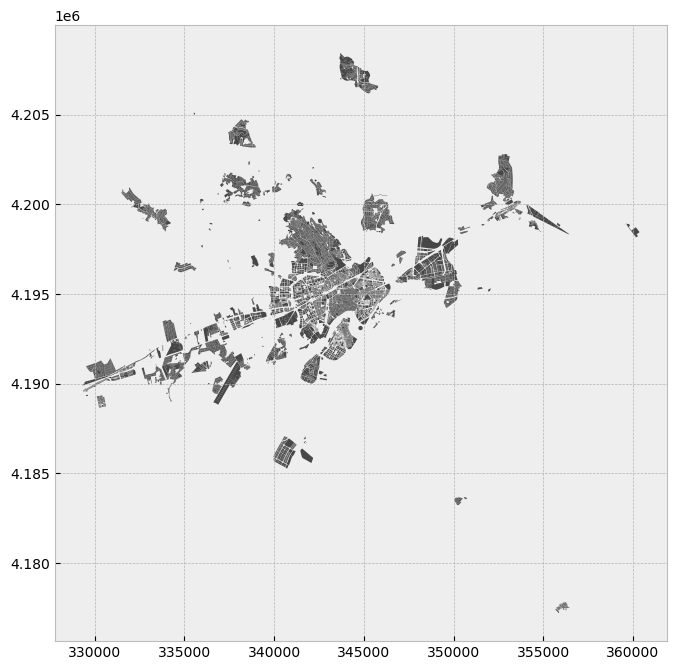

In [35]:
# Visualización de la capa
fig, ax = plt.subplots(figsize=(12, 8))
# Usar la función plot() de Geopandas para visualizar geom_df
geom_df.plot(ax=ax, color='black', alpha=0.7)

plt.show()

Una vez comprobado que el archivo de datos `geo` se encuentra en correctas condiciones para su carga en la base de datos, lo borramos para liberar memoria.

In [36]:
del geom_df

## 7.2. Carga de los datos geométricos en la geodatabase.

---
<div class="alert alert-info">
    
Se deben declarar las siguientes variables por el usuario:
    
+ **`tabla_geom`** : Nombre que se asigna a la tabla de PostgreSQL donde se cargarán los datos geo. Declarada anteriormente.

+ **`srid_geometr`** : Código EPSG del sistema de referencia a emplear. En la mayor parte de España es **25830**  (ETRS89 UTM 30N)

+ **`schema_geometr`** : Nombre que se asigna al esquema de PostgreSQL donde se cargarán los datos geo. Por defecto se emplea el definido por la variable `municipio`.

+ **`tipo_geom`** : Tipo de geometría a cargar. `POLYGON`, `POINT`, `LINESTRING`, `GEOMETRYCOLLECTION`, etc
</div>
---

In [37]:
# Variables a declarar
# tabla_geom = 'parcel' # Nombre que queremos dar a la tabla
srid_geometr = 25830  # Código EPSG para España
schema_geometr = municipio  # Usando tu variable 'municipio' como el esquema
tipo_geom = 'POLYGON'  # Tipo de geometría

Utilizando **`shp2pgsql`** de PostGIS, cargamos el fichero en la base de datos.<br>
Para obtener más información consultar el siguiente
[Enlace de uso de shp2pgsql](https://stackoverflow.com/questions/22392466/python-scripts-to-ingest-a-shapefile-into-a-postgresql-postgis-database-utilizin)

In [38]:
import os
import subprocess

# Agregar la ruta de la carpeta bin de PostgreSQL al PATH
os.environ['PATH'] += os.pathsep + pg_bin_path

# Configurar las variables de entorno de PostgreSQL
os.environ['PGHOST'] = host
os.environ['PGPORT'] = str(pgport)  # Convertir pgport a una cadena antes de asignarlo
os.environ['PGUSER'] = user
os.environ['PGPASSWORD'] = password
os.environ['PGDATABASE'] = database

# Obtener la lista de archivos Shapefile en la carpeta
shapefile_list = []
for root, dirs, files in os.walk(ruta_geom):
    for file_ in files:
        if file_[-4:].lower() == '.shp':
            shapefile_path = os.path.join(root, file_)
            shapefile_list.append(shapefile_path)

# Iterar sobre los archivos Shapefile y ejecutar shp2pgsql con índice
for shapefile_path in shapefile_list:
    table_name = tabla_geom  # Asignar el valor de tabla_geom
    shp2pgsql_cmd = f'shp2pgsql -I -s {srid_geometr} "{shapefile_path}" {schema_geometr}.{table_name} | psql'
    subprocess.call(shp2pgsql_cmd, shell=True)

Verificamos que la carga ha sido correcta.

In [39]:
try:
    # Consulta SQL comprobación de la carga
    sql = f'SELECT * FROM {municipio}.{tabla_geom};'

    # Ejecutar la consulta para copiar los datos
    cursor.execute(sql)

    # Obtener los resultados de la consulta y convertirlos a un DataFrame
    resultados = cursor.fetchall()
    df_resultados = pd.DataFrame(resultados, columns=[desc[0] for desc in cursor.description])

    # Mostrar el contenido del DataFrame
    print(df_resultados.head(3))

    # Confirmar los cambios
    conexion.commit()

    print(f"La tabla {tabla_geom} se creó con éxito en el esquema {municipio}")

except (Exception, psycopg2.Error) as error:
    print(f"Error al copiar los datos a la tabla {tabla_geom}':", error)

   gid   mapa  delegacio  municipio   masa     hoja tipo parcela      coorx  \
0    1  14009         14        900  51432  UG4954S    U      03  345026.37   
1    2  14009         14        900  51432  UG4954S    U      02  345002.08   
2    3  14009         14        900  51627  UG4956S    U      01  345065.70   

        coory  ...  fechaalta  fechabaja   ninterno    pcat1    pcat2  \
0  4194096.63  ...   20131118   99999999  285857136  5143203  UG4954S   
1  4194118.69  ...   20131118   99999999  285857137  5143202  UG4954S   
2  4195990.54  ...   20131125   99999999  286018016  5162701  UG4956S   

   ejercicio  num_exp control          refcat  \
0       None     None    None  5143203UG4954S   
1       None     None    None  5143202UG4954S   
2       None     None    None  5162701UG4956S   

                                                geom  
0  0106000020E66400000100000001030000000100000012...  
1  0106000020E66400000100000001030000000100000007...  
2  0106000020E66400000100000

Es necesario para finalizar el proceso ***ETL de extracción, transformación y carga***, cerrar todas las conexiones abiertas con la base de datos.

In [40]:
# Cerrar conexion a database con psycopg2
conexion.commit()
cursor.close()
conexion.close()

# Cerrar conexion a database con sqlalchemy
engine.dispose()